In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
import numpy as np
import matplotlib.pyplot as plt
# define grids of points
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

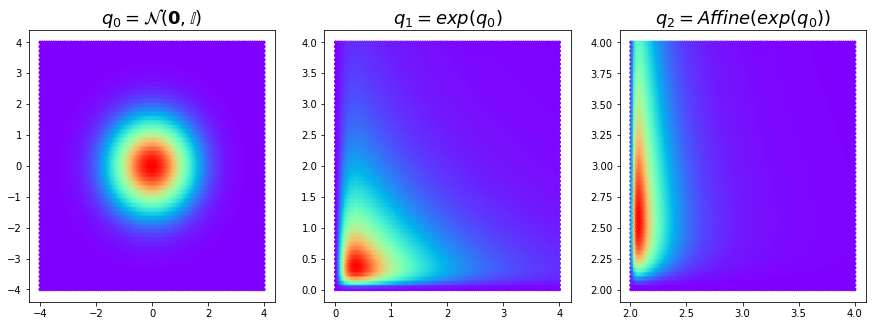

In [2]:
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
# Define an affine transform
f1 = transform.ExpTransform()
q1 = distrib.TransformedDistribution(q0, f1)
# Define an additional transform
f2 = transform.AffineTransform(2, torch.Tensor([0.2, 1.5]))
# Here I define on purpose q2 as a sequence of transforms on q0
q2 = distrib.TransformedDistribution(q0, [f1, f2])
# Plot all these lads
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=torch.exp(q0.log_prob(torch.Tensor(z))), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18)
ax2.hexbin(z[:,0], z[:,1], C=torch.exp(q1.log_prob(torch.Tensor(z))), cmap='rainbow')
ax2.set_title('$q_1=exp(q_0)$', fontsize=18)
ax3.hexbin(z[:,0], z[:,1], C=torch.exp(q2.log_prob(torch.Tensor(z))), cmap='rainbow')
ax3.set_title('$q_2=Affine(exp(q_0))$', fontsize=18)
plt.show()

In [3]:
class Flow(transform.Transform, nn.Module):
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
        
    # init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
            
    def __hash__(self):
        return nn.Module.__hash__(self)

In [4]:
class PlanarFlow(Flow):
    
    def __init__(self, dim, h=torch.tanh, hp=(lambda x: 1 - torch.tanh(x) **2)):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.h = h
        self.hp = hp
        self.init_parameters()
    
    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * self.h(f_z)
    
    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = self.hp(f_z) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)

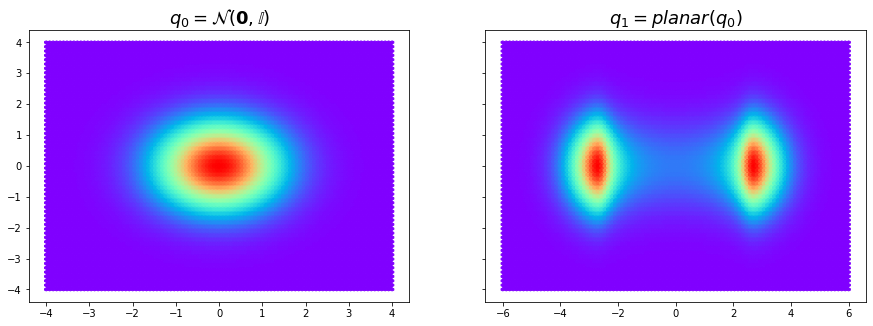

In [5]:
def change_density(q0_density, flow, z):
    # apply our transofmr on coordinates
    f_z = flow(torch.Tensor(z)).detach()
    # obtain our density
    q1_density = q0_density.squeeze() / np.exp(flow.log_abs_det_jacobian(
    torch.Tensor(z)).detach().squeeze())
    return q1_density, f_z

# our base densty
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))
# our transform
flow = PlanarFlow(2)
# manually set the transform parameters:
flow.weight.data = torch.Tensor([[4, 0]])
flow.scale.data = torch.Tensor([[2, 0]])
flow.bias.data = torch.Tensor([0])
q1_density, f_z = change_density(q0_density, flow, z)
# plot
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18)
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$', fontsize=18)
plt.show()


In [6]:
class RadialFlow(Flow):
    def __init__(self, dim):
        super(RadialFlow, self).__init__()
        self.z0 = nn.Parameter(torch.Tensor(1, dim))
        self.alpha = nn.Parameter(torch.Tensor(1))
        self.beta = nn.Parameter(torch.Tensor(1))
        self.dim = dim
        self.init_parameters()
        
    def _call(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1 / (self.alpha + r)
        return z + (self.beta * h * (z - self.z0))
    
    def log_abs_det_jacobian(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1/ (self.alpha + r)
        hp = -1 / (self.alpha + r) ** 2
        bh = self.beta * h
        det_grad = ((1 + bh) ** self.dim - 1) * (1 + bh + self.beta * hp * r)
        return torch.log(det_grad.abs() + 1e-9)
    

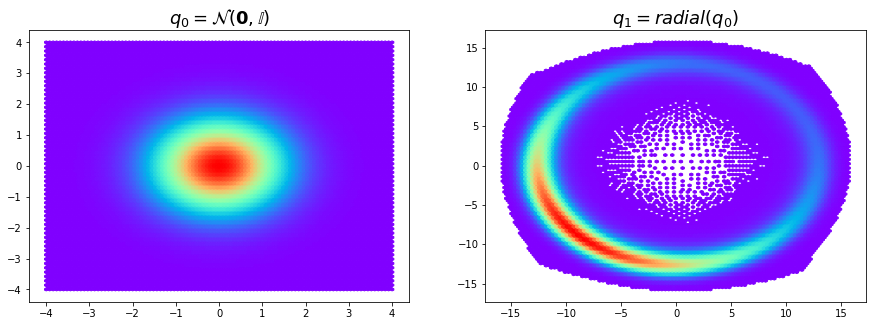

In [7]:
# our base density 
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))
# our transform
flow = RadialFlow(2)
# manually set the transform parameters
flow.z0.data = torch.Tensor([[0.5, 0.5]])
flow.alpha.data = torch.Tensor([.1]) # played around with different alpha values
flow.beta.data = torch.Tensor([12]) # played around with different beta values
q1_density, f_z = change_density(q0_density, flow, z)
# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18)
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=radial(q_0)$', fontsize=18)
plt.show()


In [8]:
class PReLUFlow(Flow):
    def __init__(self, dim):
        super(PReLUFlow, self).__init__()
        self.alpha = nn.Parameter(torch.Tensor([1]))
        self.bijective = True
        
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(0.01, 0.99)
            
    def _call(self, z):
        return torch.where(z >= 0, z, torch.abs(self.alpha) * z)
    
    def _inverse(self, z):
        torch.where(z >= 0, z, torch.abs(1. / self.alpha) * z)
        
    def log_abs_det_jacobian(self, z):
        I = torch.ones_like(z)
        J = torch.where(z >= 0, I, self.alpha * I)
        log_abs_det = torch.log(torch.abs(J) + 1e-5)
        return torch.sum(log_abs_det, dim=1)
        

tensor([8.5968e-09, 8.8608e-09, 9.1324e-09,  ..., 1.6889e-09, 1.6394e-09,
        1.5913e-09])
tensor([[-6.1770, -6.1770],
        [-6.1692, -6.1807],
        [-6.1614, -6.1843],
        ...,
        [12.2818, 12.3359],
        [12.2995, 12.3266],
        [12.3172, 12.3172]])


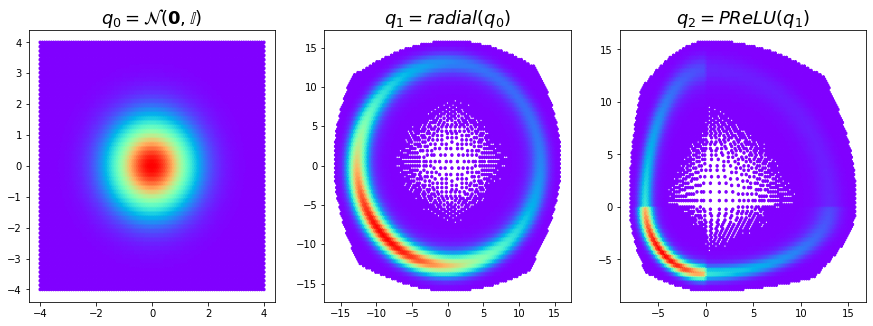

In [9]:
# our base density
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
q0_density = torch.exp(q0.log_prob(torch.Tensor(z)))
# our radial transform
flow = RadialFlow(2)
# manually set the transform parameters
flow.z0.data = torch.Tensor([[-0.5, -0.5]])
flow.alpha.data = torch.Tensor([1])
flow.beta.data = torch.Tensor([8])
q1_density, f_z2 = change_density(q1_density, flow, f_z)
# our PReLU flow
flow = PReLUFlow(2)
# manually set the transform parameters
flow.alpha.data = torch.Tensor([0.5])
q2_density, f_z2 = change_density(q1_density, flow, f_z)
print(q2_density)
print(f_z2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=q0_density.numpy().squeeze(), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18)
ax2.hexbin(f_z[:,0], f_z[:,1], C=q1_density.numpy().squeeze(), cmap='rainbow')
ax2.set_title('$q_1=radial(q_0)$', fontsize=18)
ax3.hexbin(f_z2[:,0], f_z2[:,1], C=q2_density.numpy().squeeze(), cmap='rainbow')
ax3.set_title('$q_2=PReLU(q_1)$', fontsize=18)
plt.show()

In [10]:
class BatchNormFlow(Flow):
    def __init__(self, dim , momentum=0.95, eps=1e-5):
        super(BatchNormFlow, self).__init__()
        # running batch statistics
        self.r_mean = torch.zeros(dim)
        self.r_var = torch.ones(dim)
        # momentum
        self.momentum = momentum
        self.eps = eps
        # trainable scale and shift
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
        
    def _call(self, z):
        if self.training:
            # current batch stats
            self.b_mean = z.mean(0)
            self.b_var = (z - self.b_mean).pow(2).mean(0) + self.eps
            # running mean and var
            self.r_mean = self.momentum * self.r_mean + ((1 - self.momentum) *
                                                        self.b_mean)
            self.r_var = self.momentum * self.r_var + ((1 - self.momentum) * self.b_var)
            mean = self.b_mean 
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - mean) / var.sqrt()
        y = self.gamma * x_hat + self.beta
        return y

    def _inverse(self, x):
        if self.training:
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - self.beta) / self.gamma
        y = x_hat * var.sqrt() + mean
        return y

    def log_abs_det_jacobian(self, z):
        # here we only need the variance
        mean = z.mean(0)
        var = (z - mean).pow(2).mean(0) + self.eps
        log_det = torch.log(self.gamma) - 0.5 * torch.log(var + self.eps)
        return torch.sum(log_det, -1)
            

In [11]:
# flow version of affine transform
class AffineFlow(Flow):
    def __init__(self, dim):
        super(AffineFlow, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(dim, dim))
        nn.init.orthogonal_(self.weights)
        
    def _call(self, z):
        return z @ self.weights
    
    def _inverse(self, z):
        return z @ torch.inverse(self.weights)
    
    def log_abs_det_jacobian(self, z):
        return torch.slogdet(self.weights)[-1].unsqueeze(0).repeat(z.size(0), 1)

    
        

In [12]:
from scipy import linalg as splin
# affine flow with LU decomposition
class AffineLUFlow(Flow):
    def __init__(self, dim):
        super(AffineLUFlow, self).__init__()
        weights = torch.Tensor(dim, dim)
        nn.init.orthogonal_(weights)
        # compute the parameterization
        P, L, U = splin.lu(weights.numpy())
        self.P = torch.Tensor(P)
        self.L = nn.Parameter(torch.Tensor(L))
        self.U = nn.Parameter(torch.Tensor(U))
        # need to create masks for enforcing triangular matrices
        self.mask_low = torch.tril(torch.ones(weights.size()), -1)
        self.mask_up = torch.triu(torch.ones(weights.size()), -1)
        self.I = torch.eye(weights.size(0))
        # compute s
        self.s = nn.Parameter(torch.Tensor(np.diag(U)))
        
    def _call(self, z):
        L = self.L * self.mask_low + self.I
        U = self.U * self.mask_up + torch.diag(self.s)
        weights = self.P @ L @ U
        return z @ weights
    
    def _inverse(self, z):
        L = self.L * self.mask_low + self.I
        U = self.U * self.mask_up + torch.diag(self.s)
        weights = self.P @ L @ U
        return z @ torch.inverse(self.weights)
    
    def log_abs_det_jacobian(self, z):
        return torch.sum(torch.log(torch.abs(self.s))).unsqueeze(0).repeat(z.size(0), 1)

In [13]:
# main class for normalizing flow
class NormalizingFlow(nn.Module):
    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            for b_flow in blocks:
                biject.append(b_flow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []
        
    def forward(self, z):
        self.log_det = []
        # apply series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det
    
# MLP blocks
block_mlp = [
    AffineFlow, 
    BatchNormFlow,
    PReLUFlow
]
        
# create normalizing flow
flow = NormalizingFlow(dim=2, blocks=block_mlp, flow_length=8, density=distrib.MultivariateNormal(
    torch.zeros(2), torch.eye(2)))
        
        

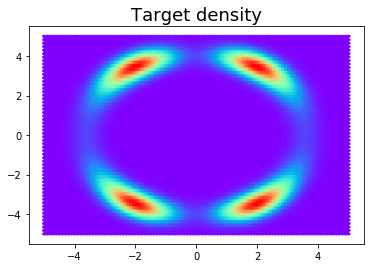

In [14]:
def density_ring(z):  
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

# Plot
x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=18)
plt.show()

In [15]:
import torch.optim as optim
# Create optimizer algorithm
optimizer = optim.Adam(flow.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)
# Define our loss
def loss(density, zk, log_jacobians):
    sum_of_log_jacobians = sum(log_jacobians)
    return (-sum_of_log_jacobians - torch.log(density(zk) + 1e-9)).mean()

Loss (it. 0) : 18.364689
Loss (it. 1000) : 1.570252
Loss (it. 2000) : 1.324267
Loss (it. 3000) : 1.170914
Loss (it. 4000) : nan
Loss (it. 5000) : nan
Loss (it. 6000) : nan
Loss (it. 7000) : nan
Loss (it. 8000) : nan
Loss (it. 9000) : nan
Loss (it. 10000) : nan


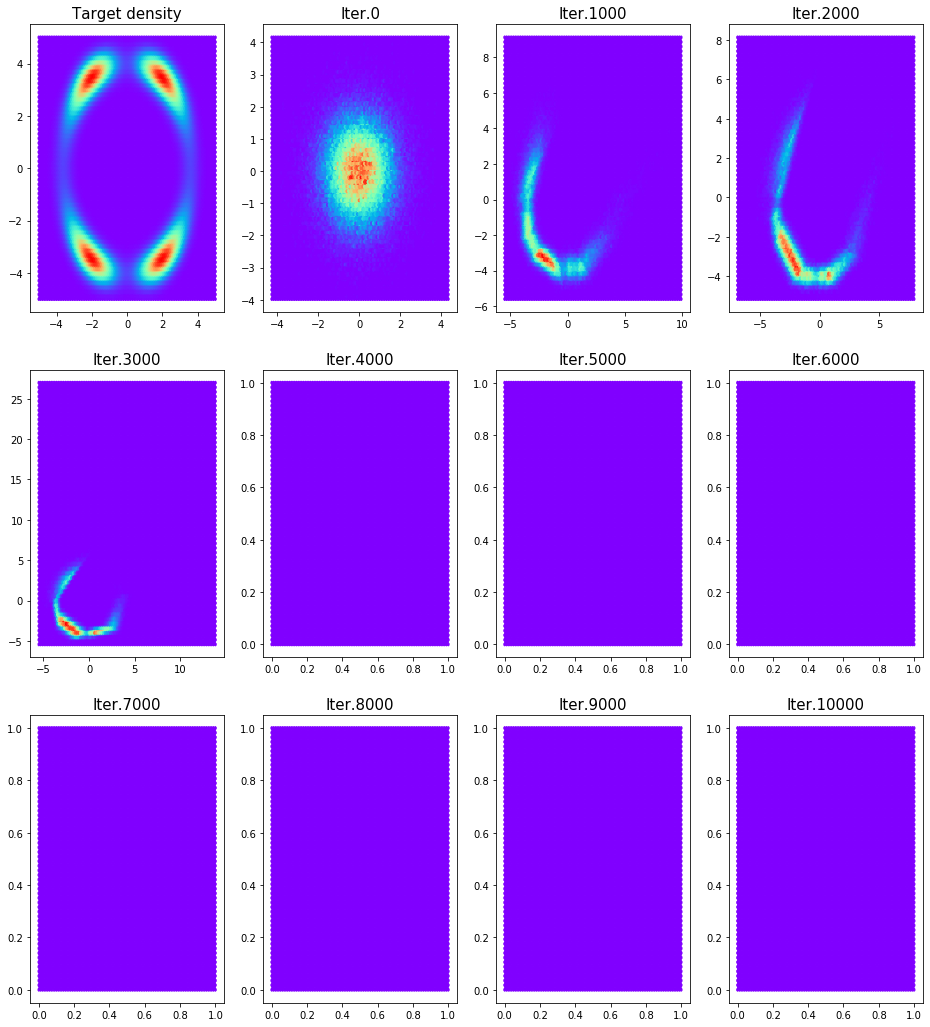

In [16]:
ref_distrib = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
id_figure=2
plt.figure(figsize=(16, 18))
plt.subplot(3,4,1)
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density', fontsize=15);
# Main optimization loop
for it in range(10001):
    # Draw a sample batch from Normal
    samples = ref_distrib.sample((512, ))
    # Evaluate flow of transforms
    zk, log_jacobians = flow(samples)
    # Evaluate loss and backprop
    optimizer.zero_grad()
    loss_v = loss(density_ring, zk, log_jacobians)
    loss_v.backward()
    optimizer.step()
    scheduler.step()
    if (it % 1000 == 0):
        print('Loss (it. %i) : %f'%(it, loss_v.item()))
        # Draw random samples
        samples = ref_distrib.sample((int(1e5), ))
        # Evaluate flow and plot
        zk, _ = flow(samples)
        zk = zk.detach().numpy()
        plt.subplot(3,4,id_figure)
        plt.hexbin(zk[:,0], zk[:,1], cmap='rainbow')
        plt.title('Iter.%i'%(it), fontsize=15);
        id_figure += 1
plt.show()